In [1]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy.io
import sys
import math
import os
import scipy.interpolate

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
c:\users\joshr\appdata\local\programs\python\python38\lib\site-packages\torch\__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


- Reference data file is loaded
- Variables are separated into individual arrays
- Reynolds and Prandtl numbers are defined

In [2]:
reference_data = np.loadtxt("cylinder_point_source.dat")
x_cell_centroid = reference_data[:, 0]
y_cell_centroid = reference_data[:, 1]
vol_weights = reference_data[:, 3]
u_mean_x = reference_data[:, 4]
u_mean_y = reference_data[:, 5]
t_mean = reference_data[:, 6]
div_uprime2_mean_x = reference_data[:, 10]
div_uprime2_mean_y = reference_data[:, 11]
g_mean = reference_data[:, 14]
Re = 150
Pr = 266.8

iters = 5
adamiters = 4000

def pde(X, V):
    # put quantities into arrays of single-value arrays
    u = V[:, 0:1]
    v = V[:, 1:2]
    p = V[:, 2:3]
    t = V[:, 3:4]
    fx = V[:, 4:5]
    fy = V[:, 5:6]
    g = V[:, 6:7]
    
    # compute partial derivatives. components i, j: i is the component from the V matrix (0 - 6 for respective properties),
    # j is component for spatial coordinate (0 - 1 for x or y)
    du_x = dde.grad.jacobian(V, X, i=0, j=0)
    dv_y = dde.grad.jacobian(V, X, i=1, j=1)
    du_y = dde.grad.jacobian(V, X, i=0, j=1)
    dv_x = dde.grad.jacobian(V, X, i=1, j=0)
    dp_x = dde.grad.jacobian(V, X, i=2, j=0)
    dp_y = dde.grad.jacobian(V, X, i=2, j=1)
    dt_x = dde.grad.jacobian(V, X, i=3, j=0)
    dt_y = dde.grad.jacobian(V, X, i=3, j=1)
    # compute partial second derivatives. First parameter is variable rather than matrix.
    # i, j are denominator spatial coordinate indices, e.g dy/dxidxj
    du_xx = dde.grad.hessian(u, X, i=0, j=0)
    dv_xx = dde.grad.hessian(v, X, i=0, j=0)
    du_yy = dde.grad.hessian(u, X, i=1, j=1)
    dv_yy = dde.grad.hessian(v, X, i=1, j=1)
    dt_xx = dde.grad.hessian(t, X, i=0, j=0)
    dt_yy = dde.grad.hessian(t, X, i=1, j=1)
    # compute partial derivatives of forcing term
    dfx_x = dde.grad.jacobian(V, X, i=4, j=0)
    dfy_y = dde.grad.jacobian(V, X, i=5, j=1)
    
    return [
        du_x + dv_y,
        u * du_x + v * du_y + dp_x - (1.0 / Re) * (du_xx + du_yy) + fx,
        u * dv_x + v * dv_y + dp_y - (1.0 / Re) * (dv_xx + dv_yy) + fy,
        dfx_x + dfy_y, 
        u * dt_x + v * dt_y - (1.0 / (Re * Pr)) * (dt_xx + dt_yy) + g
    ]

vertex_botleft = [-3, -4]
vertex_topright = [15, 4]
geom = dde.geometry.Rectangle(vertex_botleft, vertex_topright) - dde.geometry.Disk([0, 0], 0.5)
figsize = (16, 12)

Nx = int((vertex_topright[0]-vertex_botleft[0])*100)+1
Ny = int((vertex_topright[1]-vertex_botleft[1])*100)+1

def generate_training_points(x, y, u, v, t):
    x_t = []
    y_t = []
    u_t = []
    v_t = []
    t_t = []
    
    x_t = np.array(x_t)
    y_t = np.array(y_t)
    u_t = np.array(u_t)
    v_t = np.array(v_t)
    t_t = np.array(t_t)
    
    x_t = x[0::1].reshape(-1, 1)
    y_t = y[0::1].reshape(-1, 1)
    u_t = u[0::1].reshape(-1, 1)
    v_t = v[0::1].reshape(-1, 1)
    t_t = t[0::1].reshape(-1, 1)
    
    X = []
    
    for i in range(x_t.shape[0]):
        if geom.inside([x_t[i, 0], y_t[i, 0]]) \
                and x_t[i, 0] > vertex_botleft[0] and x_t[i, 0] < vertex_topright[0] \
                and y_t[i, 0] > vertex_botleft[1] and y_t[i, 0] < vertex_topright[1]:
            X.append([x_t[i, 0], y_t[i, 0], u_t[i, 0], v_t[i, 0], t_t[i, 0]])
    
    X = np.array(X)
 
    return np.hsplit(X, 5)

def plot_training_points(data, bc_ranges, bc_labels, title, figsize):
    plt.figure(figsize=figsize)
    plt.title(f"Training points for {title}")
    plt.scatter(
        data.train_x[np.sum(data.num_bcs):, 0],
        data.train_x[np.sum(data.num_bcs):, 1],
        label="Freestream collocation points", s=1.2
    )
    bc_ranges = [0] + bc_ranges
    print('BC ranges', bc_ranges)
    print('Num bcs', data.num_bcs)
    for i in range(1, 3):
        plt.scatter(
            data.train_x[
                int(np.sum(data.num_bcs[: bc_ranges[i - 1]])): np.sum(
                    data.num_bcs[: bc_ranges[i]]
                ),
                0,
            ],
            data.train_x[
                int(np.sum(data.num_bcs[: bc_ranges[i - 1]])): np.sum(
                    data.num_bcs[: bc_ranges[i]]
                ),
                1,
            ],
            label=bc_labels[i - 1], s=1.5,
        )
    plt.legend(loc=(1.05, 0.45))
    plt.xlabel("x/c")
    plt.ylabel("y/c")
    axes= plt.gca()
    axes.set_aspect(1)
    plt.tight_layout()
    plt.show()
    plt.close()
    
def func_zeros(X):
    x = X[:, 0:1]
    return x * 0

def boundary(x, on_boundary):
    return on_boundary and not(
        np.isclose(x[0], vertex_botleft[0]) or np.isclose(x[0], vertex_topright[0]) 
        or np.isclose(x[1], vertex_botleft[1]) or np.isclose(x[1], vertex_topright[1])
    )

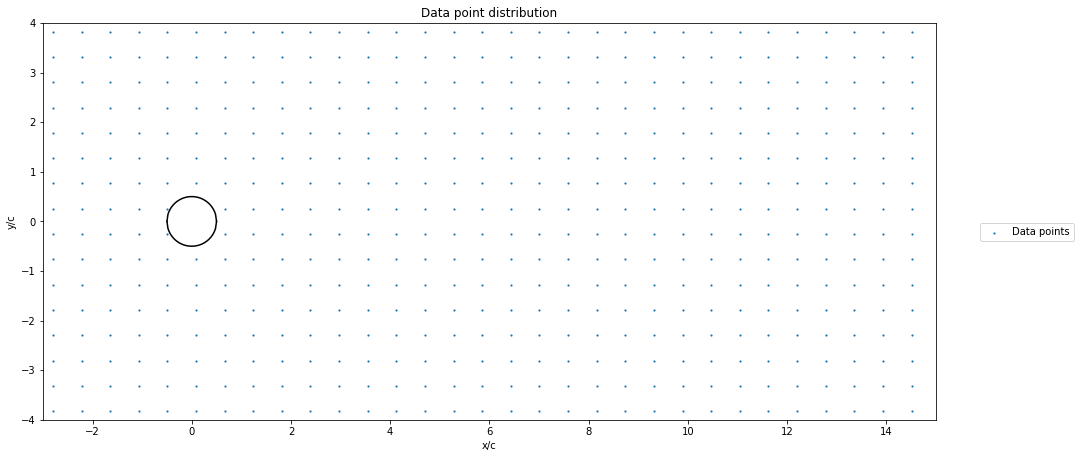

494 training points in domain
Compiling model...
'compile' took 0.637839 s

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
0         [1.80e-03, 1.66e-01, 2.84e-02, 3.94e-03, 3.30e-02, 2.50e-03, 9.12e-02, 8.17e-02, 7.14e-02, 1.55e-02, 7.42e-02, 8.16e+00, 7.73e-01, 2.37e+00]    [2.47e-03, 1.74e-01, 2.93e-02, 3.65e-03, 2.14e-02, 2.50e-03, 9.12e-02, 8.17e-02, 7.14e-02, 1.55e-02, 7.42e-02, 8.16e+00, 7.73e-01, 2.37e+00]    []  
500       [9.01e-03, 1.10e-03, 4.55e-04, 3.05e-04, 8.59e-04, 2.89e-02, 4.09e-03, 1.28e-02, 8.59e-05, 4.91e-05, 1.14e-05, 4.99e-02, 1.93e-02, 9.68e-01]    [2.20e-02, 7.64e-04, 4.26e-04, 3.95e-04, 6.14e-04, 2.89e-02, 4.09e-03, 1.28e-02, 8.59e-05, 4.91e-05, 1.14e-05, 4.99e-02, 1.93e-02, 9.68e-0

'models/prediction-0-1000.pt'

In [3]:
points = np.zeros((len(x_cell_centroid), 2))
for i in range(len(x_cell_centroid)):
    points[i][0] = x_cell_centroid[i]
    points[i][1] = y_cell_centroid[i]

# integer before 'j' = (number of points in x or y) + 1    
    
grid_x, grid_y = np.mgrid[-14.9167:39.9:96j, -9.95:9.95:40j]
num_x = np.shape(grid_x)[0]
num_y = np.shape(grid_y)[1]

gridu = scipy.interpolate.griddata(points, u_mean_x, (grid_x, grid_y)).T
gridv = scipy.interpolate.griddata(points, u_mean_y, (grid_x, grid_y)).T
gridt = scipy.interpolate.griddata(points, t_mean, (grid_x, grid_y)).T

# now need to generate new x and y points using linspace

x_line = np.linspace(-14.9167, 39.9, num_x)
y_line = np.linspace(-9.95, 9.95, num_y)
    
# reformat new_grid u data to be same shape as x and y

current_y = np.zeros(num_x)
new_x = []
new_y = []
new_u = []
new_v = []
new_t = []
for i in range(num_y):
    for j in range(num_x):
        current_y[j] = y_line[i]
    new_y = np.concatenate((new_y, current_y))
    new_x = np.concatenate((new_x, x_line))
    new_u = np.concatenate((new_u, gridu[i]))
    new_v = np.concatenate((new_v, gridv[i]))
    new_t = np.concatenate((new_t, gridt[i]))

# integer before 'j' = (number of points in x or y) + 1    
    
new_x = np.array(new_x)
new_y = np.array(new_y)
new_u = np.array(new_u)
new_v = np.array(new_v)
new_t = np.array(new_t)

[x_training, y_training, u_training, v_training, t_training] = \
    generate_training_points(new_x, new_y, new_u, new_v, new_t)

training_points = np.hstack((x_training, y_training))

tx = []
ty = []
for i in range(0, len(training_points)):
    tx.append(training_points[i][0])
    ty.append(training_points[i][1])
    
cylinderx = np.linspace(-0.5, 0.5, 50)
cylindery = np.sqrt(0.5**2 - cylinderx**2)
plt.figure(figsize=figsize)
plt.scatter(tx, ty, s=1.4, label="Data points")
plt.plot(cylinderx, cylindery, color='k')
plt.plot(cylinderx, -cylindery, color='k')
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlim([-3.0, 15.0])
axes.set_ylim([-4.0, 4.0])
axes.set_title("Data point distribution")
plt.xlabel("x/c")
plt.ylabel("y/c")
plt.legend(loc=(1.05, 0.45))
plt.show()
plt.close()
print(str(len(training_points)) + " training points in domain")

# u, v dirichlet BCs at each point in training_points
u_training_points = dde.PointSetBC(training_points, u_training, component=0)
v_training_points = dde.PointSetBC(training_points, v_training, component=1)
t_training_points = dde.PointSetBC(training_points, t_training, component=3)
# dirichlet BCs at walls, component indices from pde function
bc_wall_u = dde.DirichletBC(geom, func_zeros, boundary, component=0)
bc_wall_v = dde.DirichletBC(geom, func_zeros, boundary, component=1)
bc_wall_t = dde.NeumannBC(geom, func_zeros, boundary, component=3)
bc_wall_fx = dde.DirichletBC(geom, func_zeros, boundary, component=4)
bc_wall_fy = dde.DirichletBC(geom, func_zeros, boundary, component=5)
bc_wall_g = dde.NeumannBC(geom, func_zeros, boundary, component=6)

data = dde.data.PDE(
    geom, pde, 
    [bc_wall_u, bc_wall_v, bc_wall_t, bc_wall_fx, bc_wall_fy, bc_wall_g, u_training_points, v_training_points, t_training_points], 
    25000, 2000, solution=None, num_test=10, 
)

layer_size = [2] + [100] * 7 + [7]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

loss_weights = [1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10]
model.compile("adam", lr=0.001, loss_weights=loss_weights)

losshistory, train_state = model.train(adamiters, display_every=500)

model.save("models/prediction-0")

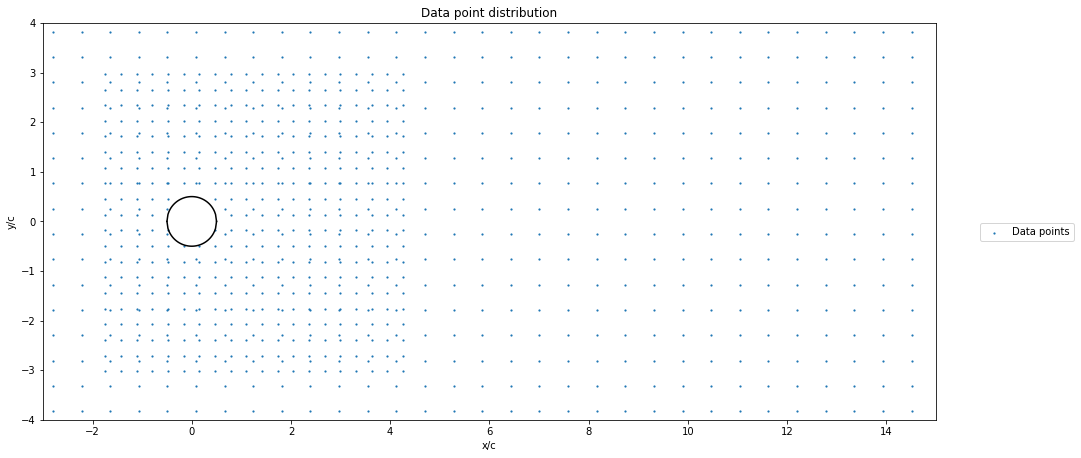

886 training points in domain
Compiling model...
'compile' took 0.000411 s

Compiling model...
'compile' took 0.000512 s

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
0         [6.24e-03, 1.66e-03, 7.46e-04, 5.98e-04, 1.63e-03, 4.59e-03, 1.65e-03, 1.27e-02, 1.98e-04, 1.71e-04, 1.63e-04, 3.90e-02, 1.76e-02, 1.42e+00]    [8.36e-04, 6.07e-04, 6.52e-04, 4.54e-05, 1.26e-04, 4.59e-03, 1.65e-03, 1.27e-02, 1.98e-04, 1.71e-04, 1.63e-04, 3.90e-02, 1.76e-02, 1.42e+00]    []  
500       [4.55e-03, 3.68e-03, 2.89e-03, 2.31e-03, 4.99e-03, 6.63e-04, 4.76e-04, 1.14e-02, 2.45e-04, 2.70e-04, 4.60e-04, 8.57e-03, 7.10e-03, 1.01e+00]    [2.41e-03, 6.51e-04, 3.26e-04, 3.77e-04, 1.64e-03, 6.63e-04, 4.76e-04, 1.14e-02, 2.45e-04, 2

KeyboardInterrupt: 

In [4]:
for k in range(iters):
    x_plot = np.linspace(vertex_botleft[0], vertex_topright[0], Nx)
    y_plot = np.linspace(vertex_botleft[1], vertex_topright[1], Ny)

    # define prediction points
    z = np.array([np.array([i, j]) for i in x_plot for j in y_plot])

    # predict fields
    y = model.predict(z)
    u_star = y[:, 0][:, None]
    v_star = y[:, 1][:, None]
    p_star = y[:, 2][:, None]
    t_star = y[:, 3][:, None]
    fx_star = y[:, 4][:, None]
    fy_star = y[:, 5][:, None]
    g_star = y[:, 6][:, None]

    u_star_data = deepcopy(u_star)
    v_star_data = deepcopy(v_star)
    p_star_data = deepcopy(p_star)
    t_star_data = deepcopy(t_star)
    fx_star_data = deepcopy(fx_star)
    fy_star_data = deepcopy(fy_star)
    g_star_data = deepcopy(g_star)

    # remove inside points
    bad_indices = []
    for i in range(len(z)):
        if(np.sqrt(z[i][0]**2 + z[i][1]**2) < 0.5):
            bad_indices.append(i)

    for i in range(len(bad_indices)):
        u_star_data[bad_indices[i]][0] = 0
        v_star_data[bad_indices[i]][0] = 0
        p_star_data[bad_indices[i]][0] = 0
        t_star_data[bad_indices[i]][0] = 0
        fx_star_data[bad_indices[i]][0] = 0
        fy_star_data[bad_indices[i]][0] = 0
        g_star_data[bad_indices[i]][0] = 0

    u_star_data = u_star_data.reshape(Nx, Ny).T
    v_star_data = v_star_data.reshape(Nx, Ny).T
    p_star_data = p_star_data.reshape(Nx, Ny).T
    t_star_data = t_star_data.reshape(Nx, Ny).T
    fx_star_data = fx_star_data.reshape(Nx, Ny).T
    fy_star_data = fy_star_data.reshape(Nx, Ny).T
    g_star_data = g_star_data.reshape(Nx, Ny).T

    X, Y = np.meshgrid(x_plot, y_plot)

    # get points of highest scalar concentration

    t_finding = deepcopy(t_star_data)

    max_ts = np.zeros(100)
    max_x = np.zeros(100)
    max_y = np.zeros(100)

    for i in range(len(max_ts)):
        max_ts[i] = np.max(t_finding)
        max_x[i] = X[np.unravel_index(np.argmax(t_finding), t_finding.shape)]
        max_y[i] = Y[np.unravel_index(np.argmax(t_finding), t_finding.shape)]
        t_finding[np.unravel_index(np.argmax(t_finding), t_finding.shape)] = 0

    new_grid_centre = [np.mean(max_x), np.mean(max_y)]

    new_grid_x_range = [new_grid_centre[0]-(1.4**(4-k)), new_grid_centre[0]+(1.4**(4-k))]
    new_grid_y_range = [new_grid_centre[1]-(1.4**(4-k)), new_grid_centre[1]+(1.4**(4-k))]

    grid_x2, grid_y2 = np.mgrid[new_grid_x_range[0]:new_grid_x_range[1]:20j, new_grid_y_range[0]:new_grid_y_range[1]:20j]
    num_x2 = np.shape(grid_x2)[0]
    num_y2 = np.shape(grid_y2)[1]

    gridu2 = scipy.interpolate.griddata(points, u_mean_x, (grid_x2, grid_y2)).T
    gridv2 = scipy.interpolate.griddata(points, u_mean_y, (grid_x2, grid_y2)).T
    gridt2 = scipy.interpolate.griddata(points, t_mean, (grid_x2, grid_y2)).T

    # now need to generate new x and y points using linspace

    x_line2 = np.linspace(new_grid_x_range[0], new_grid_x_range[1], num_x2)
    y_line2 = np.linspace(new_grid_y_range[0], new_grid_y_range[1], num_y2)

    # reformat new_grid u data to be same shape as x and y

    current_y2 = np.zeros(num_x2)
    new_x2 = []
    new_y2 = []
    new_u2 = []
    new_v2 = []
    new_t2 = []
    for i in range(num_y2):
        for j in range(num_x2):
            current_y2[j] = y_line2[i]
        new_y2 = np.concatenate((new_y2, current_y2))
        new_x2 = np.concatenate((new_x2, x_line2))
        new_u2 = np.concatenate((new_u2, gridu2[i]))
        new_v2 = np.concatenate((new_v2, gridv2[i]))
        new_t2 = np.concatenate((new_t2, gridt2[i]))

    new_x = np.concatenate((new_x, new_x2))
    new_y = np.concatenate((new_y, new_y2))
    new_u = np.concatenate((new_u, new_u2))
    new_v = np.concatenate((new_v, new_v2))
    new_t = np.concatenate((new_t, new_t2))

    new_x = np.array(new_x)
    new_y = np.array(new_y)
    new_u = np.array(new_u)
    new_v = np.array(new_v)
    new_t = np.array(new_t)

    [x_training, y_training, u_training, v_training, t_training] = \
        generate_training_points(new_x, new_y, new_u, new_v, new_t)

    training_points = np.hstack((x_training, y_training))

    tx = []
    ty = []
    for i in range(0, len(training_points)):
        tx.append(training_points[i][0])
        ty.append(training_points[i][1])

    cylinderx = np.linspace(-0.5, 0.5, 50)
    cylindery = np.sqrt(0.5**2 - cylinderx**2)
    plt.figure(figsize=figsize)
    plt.scatter(tx, ty, s=1.4, label="Data points")
    plt.plot(cylinderx, cylindery, color='k')
    plt.plot(cylinderx, -cylindery, color='k')
    axes = plt.gca()
    axes.set_aspect(1)
    axes.set_xlim([-3.0, 15.0])
    axes.set_ylim([-4.0, 4.0])
    axes.set_title("Data point distribution")
    plt.xlabel("x/c")
    plt.ylabel("y/c")
    plt.legend(loc=(1.05, 0.45))
    plt.show()
    plt.close()
    print(str(len(training_points)) + " training points in domain")

    # u, v dirichlet BCs at each point in training_points
    u_training_points = dde.PointSetBC(training_points, u_training, component=0)
    v_training_points = dde.PointSetBC(training_points, v_training, component=1)
    t_training_points = dde.PointSetBC(training_points, t_training, component=3)
    # dirichlet BCs at walls, component indices from pde function
    bc_wall_u = dde.DirichletBC(geom, func_zeros, boundary, component=0)
    bc_wall_v = dde.DirichletBC(geom, func_zeros, boundary, component=1)
    bc_wall_t = dde.DirichletBC(geom, func_zeros, boundary, component=3)
    bc_wall_fx = dde.DirichletBC(geom, func_zeros, boundary, component=4)
    bc_wall_fy = dde.DirichletBC(geom, func_zeros, boundary, component=5)
    bc_wall_g = dde.DirichletBC(geom, func_zeros, boundary, component=6)

    data = dde.data.PDE(
        geom, pde, 
        [bc_wall_u, bc_wall_v, bc_wall_t, bc_wall_fx, bc_wall_fy, bc_wall_g, u_training_points, v_training_points, t_training_points], 
        25000, 2000, solution=None, num_test=10, 
    )

    layer_size = [2] + [100] * 7 + [7]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.maps.FNN(layer_size, activation, initializer)

    loss_weights = [1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10]
    model = dde.Model(data, net)
    temp_model = deepcopy(model)
    temp_model.compile("adam", lr=0.001, loss_weights=loss_weights)

    if(k==0):
        temp_model.restore("models/prediction-" + str(k) + "-" + str(adamiters) + ".pt")
        model.net.load_state_dict(temp_model.state_dict())
        model.compile("adam", lr=0.001, loss_weights=loss_weights)
        losshistory, train_state = model.train(adamiters, display_every=500)
    elif(k==1):
        temp_model.compile("L-BFGS-B", loss_weights=loss_weights)
        temp_model.restore("models/prediction-" + str(k) + "-" + str(adamiters + bfgsiters) + ".pt")
        model.net.load_state_dict(temp_model.state_dict())
    else:
        temp_model.compile("L-BFGS-B", loss_weights=loss_weights)
        temp_model.restore("models2/prediction-" + str(k) + "-" + str(bfgsiters) + ".pt")
        model.net.load_state_dict(temp_model.state_dict())

    model.compile("L-BFGS-B", loss_weights=loss_weights)
    dde.optimizers.config.set_LBFGS_options(maxiter=bfgsiters)
    losshistory, train_state = model.train()

    model.save("models/prediction-" + str(k+1))

# Post processing

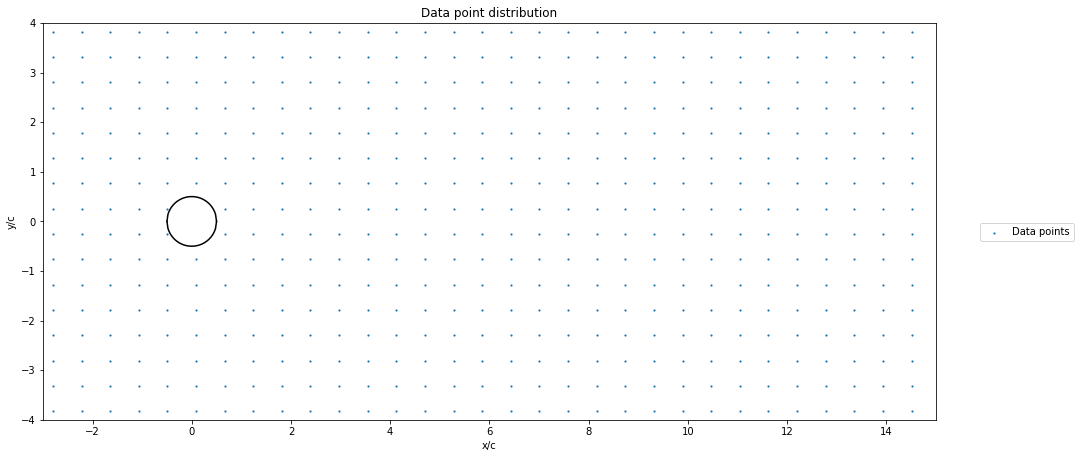

494 training points in domain
Compiling model...
'compile' took 0.561997 s



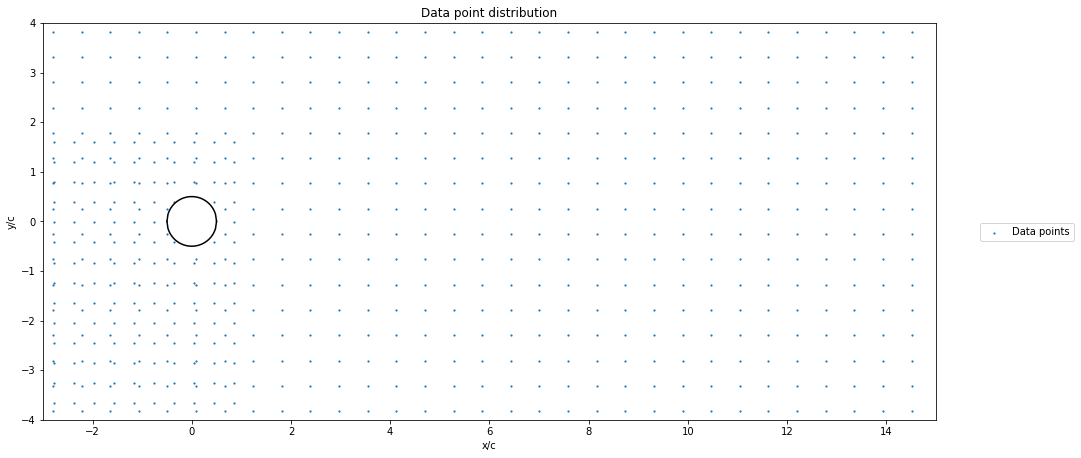

629 training points in domain
Compiling model...
'compile' took 0.000428 s

Compiling model...
'compile' took 0.000381 s

Compiling model...
'compile' took 0.000476 s



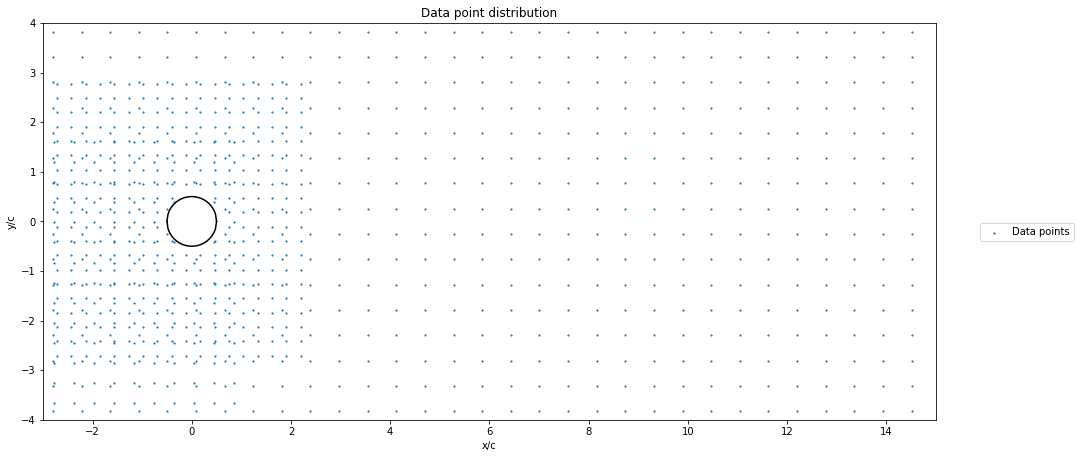

977 training points in domain
Compiling model...
'compile' took 0.000449 s

Compiling model...
'compile' took 0.000356 s

Compiling model...
'compile' took 0.000523 s



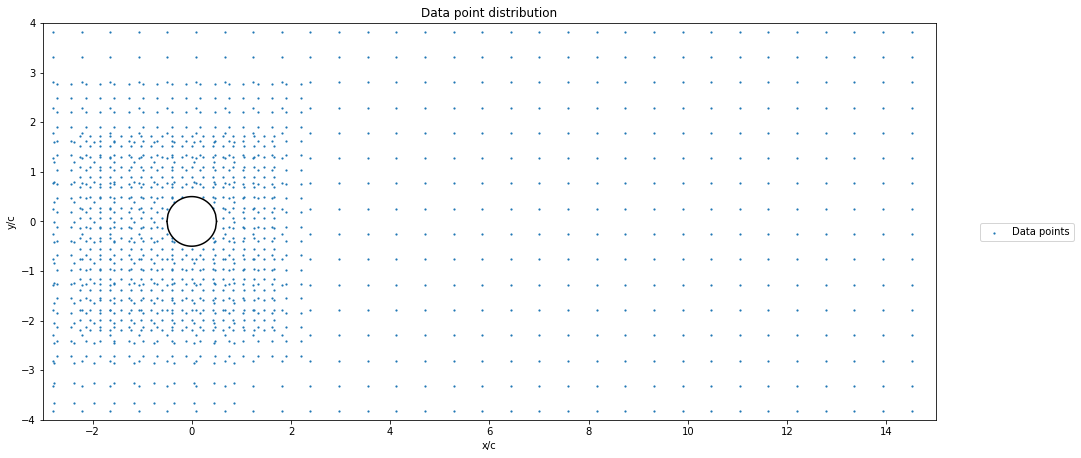

1359 training points in domain
Compiling model...
'compile' took 0.000443 s

Compiling model...
'compile' took 0.000350 s

Compiling model...
'compile' took 0.000521 s



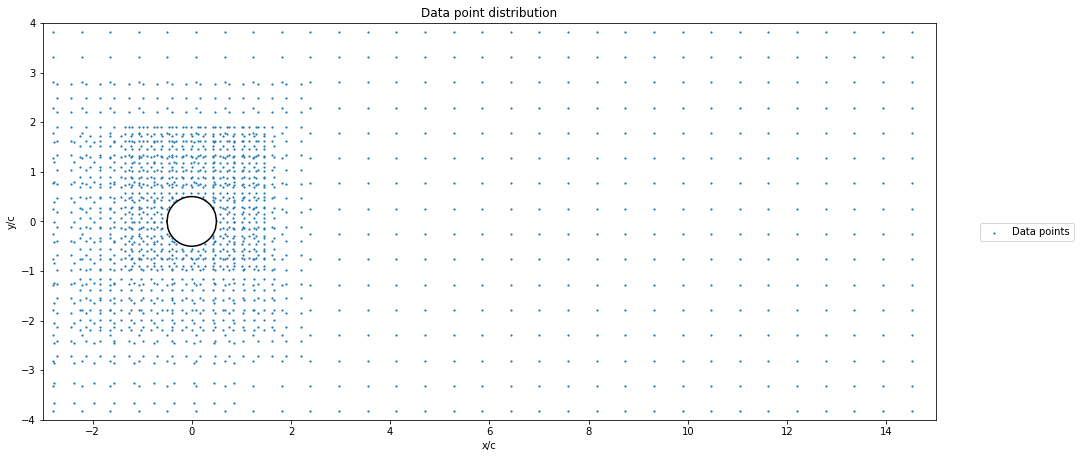

1722 training points in domain
Compiling model...
'compile' took 0.000421 s

Compiling model...
'compile' took 0.000365 s

Compiling model...
'compile' took 0.000543 s



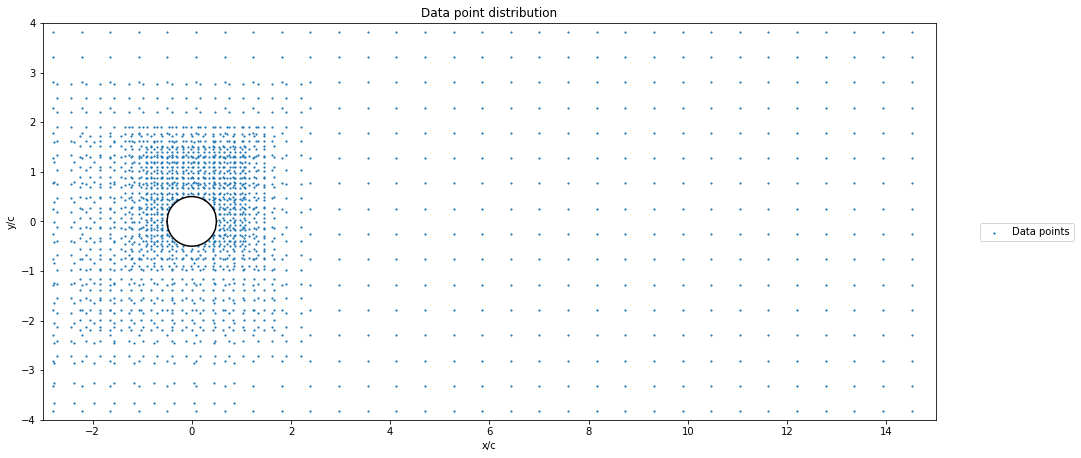

2050 training points in domain
Compiling model...
'compile' took 0.000415 s

Compiling model...
'compile' took 0.000366 s

Compiling model...
'compile' took 0.000487 s



In [3]:
points = np.zeros((len(x_cell_centroid), 2))
for i in range(len(x_cell_centroid)):
    points[i][0] = x_cell_centroid[i]
    points[i][1] = y_cell_centroid[i]

# integer before 'j' = (number of points in x or y) + 1    
    
grid_x, grid_y = np.mgrid[-14.9167:39.9:96j, -9.95:9.95:40j]
num_x = np.shape(grid_x)[0]
num_y = np.shape(grid_y)[1]

gridu = scipy.interpolate.griddata(points, u_mean_x, (grid_x, grid_y)).T
gridv = scipy.interpolate.griddata(points, u_mean_y, (grid_x, grid_y)).T
gridt = scipy.interpolate.griddata(points, t_mean, (grid_x, grid_y)).T

# now need to generate new x and y points using linspace

x_line = np.linspace(-14.9167, 39.9, num_x)
y_line = np.linspace(-9.95, 9.95, num_y)
    
# reformat new_grid u data to be same shape as x and y

current_y = np.zeros(num_x)
new_x = []
new_y = []
new_u = []
new_v = []
new_t = []
for i in range(num_y):
    for j in range(num_x):
        current_y[j] = y_line[i]
    new_y = np.concatenate((new_y, current_y))
    new_x = np.concatenate((new_x, x_line))
    new_u = np.concatenate((new_u, gridu[i]))
    new_v = np.concatenate((new_v, gridv[i]))
    new_t = np.concatenate((new_t, gridt[i]))

# integer before 'j' = (number of points in x or y) + 1    
    
new_x = np.array(new_x)
new_y = np.array(new_y)
new_u = np.array(new_u)
new_v = np.array(new_v)
new_t = np.array(new_t)

[x_training, y_training, u_training, v_training, t_training] = \
    generate_training_points(new_x, new_y, new_u, new_v, new_t)

training_points = np.hstack((x_training, y_training))

tx = []
ty = []
for i in range(0, len(training_points)):
    tx.append(training_points[i][0])
    ty.append(training_points[i][1])
    
cylinderx = np.linspace(-0.5, 0.5, 50)
cylindery = np.sqrt(0.5**2 - cylinderx**2)
plt.figure(figsize=figsize)
plt.scatter(tx, ty, s=1.4, label="Data points")
plt.plot(cylinderx, cylindery, color='k')
plt.plot(cylinderx, -cylindery, color='k')
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlim([-3.0, 15.0])
axes.set_ylim([-4.0, 4.0])
axes.set_title("Data point distribution")
plt.xlabel("x/c")
plt.ylabel("y/c")
plt.legend(loc=(1.05, 0.45))
plt.show()
plt.close()
print(str(len(training_points)) + " training points in domain")

u_training_points = dde.PointSetBC(training_points, u_training, component=0)
v_training_points = dde.PointSetBC(training_points, v_training, component=1)
t_training_points = dde.PointSetBC(training_points, t_training, component=3)
# dirichlet BCs at walls, component indices from pde function
bc_wall_u = dde.DirichletBC(geom, func_zeros, boundary, component=0)
bc_wall_v = dde.DirichletBC(geom, func_zeros, boundary, component=1)
bc_wall_t = dde.DirichletBC(geom, func_zeros, boundary, component=3)
bc_wall_fx = dde.DirichletBC(geom, func_zeros, boundary, component=4)
bc_wall_fy = dde.DirichletBC(geom, func_zeros, boundary, component=5)
bc_wall_g = dde.DirichletBC(geom, func_zeros, boundary, component=6)

data = dde.data.PDE(
    geom, pde, 
    [bc_wall_u, bc_wall_v, bc_wall_t, bc_wall_fx, bc_wall_fy, bc_wall_g, u_training_points, v_training_points, t_training_points], 
    25000, 2000, solution=None, num_test=10, 
)

layer_size = [2] + [100] * 7 + [7]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

loss_weights = [1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10]
model.compile("adam", lr=0.001, loss_weights=loss_weights)

for k in range(iters):
    x_plot = np.linspace(vertex_botleft[0], vertex_topright[0], Nx)
    y_plot = np.linspace(vertex_botleft[1], vertex_topright[1], Ny)

    # define prediction points
    z = np.array([np.array([i, j]) for i in x_plot for j in y_plot])

    # predict fields
    y = model.predict(z)
    u_star = y[:, 0][:, None]
    v_star = y[:, 1][:, None]
    p_star = y[:, 2][:, None]
    t_star = y[:, 3][:, None]
    fx_star = y[:, 4][:, None]
    fy_star = y[:, 5][:, None]
    g_star = y[:, 6][:, None]

    u_star_data = deepcopy(u_star)
    v_star_data = deepcopy(v_star)
    p_star_data = deepcopy(p_star)
    t_star_data = deepcopy(t_star)
    fx_star_data = deepcopy(fx_star)
    fy_star_data = deepcopy(fy_star)
    g_star_data = deepcopy(g_star)

    # remove inside points
    bad_indices = []
    for i in range(len(z)):
        if(np.sqrt(z[i][0]**2 + z[i][1]**2) < 0.5):
            bad_indices.append(i)

    for i in range(len(bad_indices)):
        u_star_data[bad_indices[i]][0] = 0
        v_star_data[bad_indices[i]][0] = 0
        p_star_data[bad_indices[i]][0] = 0
        t_star_data[bad_indices[i]][0] = 0
        fx_star_data[bad_indices[i]][0] = 0
        fy_star_data[bad_indices[i]][0] = 0
        g_star_data[bad_indices[i]][0] = 0

    u_star_data = u_star_data.reshape(Nx, Ny).T
    v_star_data = v_star_data.reshape(Nx, Ny).T
    p_star_data = p_star_data.reshape(Nx, Ny).T
    t_star_data = t_star_data.reshape(Nx, Ny).T
    fx_star_data = fx_star_data.reshape(Nx, Ny).T
    fy_star_data = fy_star_data.reshape(Nx, Ny).T
    g_star_data = g_star_data.reshape(Nx, Ny).T

    X, Y = np.meshgrid(x_plot, y_plot)

    # get points of highest scalar concentration

    t_finding = deepcopy(t_star_data)

    max_ts = np.zeros(100)
    max_x = np.zeros(100)
    max_y = np.zeros(100)

    for i in range(len(max_ts)):
        max_ts[i] = np.max(t_finding)
        max_x[i] = X[np.unravel_index(np.argmax(t_finding), t_finding.shape)]
        max_y[i] = Y[np.unravel_index(np.argmax(t_finding), t_finding.shape)]
        t_finding[np.unravel_index(np.argmax(t_finding), t_finding.shape)] = 0

    new_grid_centre = [np.mean(max_x), np.mean(max_y)]

    new_grid_x_range = [new_grid_centre[0]-(1.4**(4-k)), new_grid_centre[0]+(1.4**(4-k))]
    new_grid_y_range = [new_grid_centre[1]-(1.4**(4-k)), new_grid_centre[1]+(1.4**(4-k))]

    grid_x2, grid_y2 = np.mgrid[new_grid_x_range[0]:new_grid_x_range[1]:20j, new_grid_y_range[0]:new_grid_y_range[1]:20j]
    num_x2 = np.shape(grid_x2)[0]
    num_y2 = np.shape(grid_y2)[1]

    gridu2 = scipy.interpolate.griddata(points, u_mean_x, (grid_x2, grid_y2)).T
    gridv2 = scipy.interpolate.griddata(points, u_mean_y, (grid_x2, grid_y2)).T
    gridt2 = scipy.interpolate.griddata(points, t_mean, (grid_x2, grid_y2)).T

    # now need to generate new x and y points using linspace

    x_line2 = np.linspace(new_grid_x_range[0], new_grid_x_range[1], num_x2)
    y_line2 = np.linspace(new_grid_y_range[0], new_grid_y_range[1], num_y2)

    # reformat new_grid u data to be same shape as x and y

    current_y2 = np.zeros(num_x2)
    new_x2 = []
    new_y2 = []
    new_u2 = []
    new_v2 = []
    new_t2 = []
    for i in range(num_y2):
        for j in range(num_x2):
            current_y2[j] = y_line2[i]
        new_y2 = np.concatenate((new_y2, current_y2))
        new_x2 = np.concatenate((new_x2, x_line2))
        new_u2 = np.concatenate((new_u2, gridu2[i]))
        new_v2 = np.concatenate((new_v2, gridv2[i]))
        new_t2 = np.concatenate((new_t2, gridt2[i]))

    new_x = np.concatenate((new_x, new_x2))
    new_y = np.concatenate((new_y, new_y2))
    new_u = np.concatenate((new_u, new_u2))
    new_v = np.concatenate((new_v, new_v2))
    new_t = np.concatenate((new_t, new_t2))

    new_x = np.array(new_x)
    new_y = np.array(new_y)
    new_u = np.array(new_u)
    new_v = np.array(new_v)
    new_t = np.array(new_t)

    [x_training, y_training, u_training, v_training, t_training] = \
        generate_training_points(new_x, new_y, new_u, new_v, new_t)

    training_points = np.hstack((x_training, y_training))

    tx = []
    ty = []
    for i in range(0, len(training_points)):
        tx.append(training_points[i][0])
        ty.append(training_points[i][1])

    cylinderx = np.linspace(-0.5, 0.5, 50)
    cylindery = np.sqrt(0.5**2 - cylinderx**2)
    plt.figure(figsize=figsize)
    plt.scatter(tx, ty, s=1.4, label="Data points")
    plt.plot(cylinderx, cylindery, color='k')
    plt.plot(cylinderx, -cylindery, color='k')
    axes = plt.gca()
    axes.set_aspect(1)
    axes.set_xlim([-3.0, 15.0])
    axes.set_ylim([-4.0, 4.0])
    axes.set_title("Data point distribution")
    plt.xlabel("x/c")
    plt.ylabel("y/c")
    plt.legend(loc=(1.05, 0.45))
    plt.show()
    plt.close()
    print(str(len(training_points)) + " training points in domain")
    
    u_training_points = dde.PointSetBC(training_points, u_training, component=0)
    v_training_points = dde.PointSetBC(training_points, v_training, component=1)
    t_training_points = dde.PointSetBC(training_points, t_training, component=3)
    # dirichlet BCs at walls, component indices from pde function
    bc_wall_u = dde.DirichletBC(geom, func_zeros, boundary, component=0)
    bc_wall_v = dde.DirichletBC(geom, func_zeros, boundary, component=1)
    bc_wall_t = dde.DirichletBC(geom, func_zeros, boundary, component=3)
    bc_wall_fx = dde.DirichletBC(geom, func_zeros, boundary, component=4)
    bc_wall_fy = dde.DirichletBC(geom, func_zeros, boundary, component=5)
    bc_wall_g = dde.DirichletBC(geom, func_zeros, boundary, component=6)

    data = dde.data.PDE(
        geom, pde, 
        [bc_wall_u, bc_wall_v, bc_wall_t, bc_wall_fx, bc_wall_fy, bc_wall_g, u_training_points, v_training_points, t_training_points], 
        25000, 2000, solution=None, num_test=10, 
    )

    layer_size = [2] + [100] * 7 + [7]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.maps.FNN(layer_size, activation, initializer)

    loss_weights = [1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10]
    model = dde.Model(data, net)
    temp_model = deepcopy(model)
    temp_model.compile("adam", lr=0.001, loss_weights=loss_weights)

    if(k==0):
        temp_model.restore("models/prediction-" + str(k) + "-" + str(adamiters) + ".pt")
        model.net.load_state_dict(temp_model.state_dict())
        model.compile("adam", lr=0.001, loss_weights=loss_weights)
    elif(k==1):
        temp_model.compile("L-BFGS-B", loss_weights=loss_weights)
        temp_model.restore("models/prediction-" + str(k) + "-" + str(adamiters + bfgsiters) + ".pt")
        model.net.load_state_dict(temp_model.state_dict())
    else:
        temp_model.compile("L-BFGS-B", loss_weights=loss_weights)
        temp_model.restore("models/prediction-" + str(k) + "-" + str(bfgsiters) + ".pt")
        model.net.load_state_dict(temp_model.state_dict())
        
    bfgsiters = int(round(((100*np.emath.logn(1.03, k+1))+3000)/1000))*1000
    model.compile("L-BFGS-B", loss_weights=loss_weights)